In [1]:
import matplotlib.pyplot as plt
import os
import tqdm
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import numpy as np
from importlib import reload
import pygame

import GamePhysicsSim as GPS
import GamePhysicsSim.Pod as PodClass
from GamePhysicsSim.Config import conf,ROOT_DIR
import GamePhysicsSim.NN as NN
import GamePhysicsSim.Visualise as Visualise

import GamePhysicsSim.Utils as Utils


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
import sklearn
from sklearn import preprocessing
import pickle

### Test manual driving

In [5]:
imgFile = os.path.join(ROOT_DIR,'images/SpaceShip2.png')
Visualise.RunManualControl(imgFile,conf)

### Train regression model instead of classifier

Next we follow https://www.tensorflow.org/tutorials/keras/regression

Look at different activation functions over at https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/

### Generate data on which to train a single AI for starters

In [7]:
reload(GPS)
reload(GPS.PhysicalObjects)
reload(GPS.Utils)
reload(PodClass)
reload(GPS.Config)
reload(Utils)
reload(NN)

import GamePhysicsSim as GPS
import GamePhysicsSim.Pod as PodClass
from GamePhysicsSim.Config import conf
import GamePhysicsSim.Utils as Utils

In [27]:
pod.pid?

In [37]:
K0 = 10
f0 = 0.12
Kp = K0 * 1
Ki = 5 * Kp * f0
Kd = Kp / (8*f0)
pod.PID_init(Kp,Ki,Kd)
pod.pid.proportional_on_measurement = False
print(pod.pid(1.268470063651272,1/30))
print(pod.pid(1.1637503085316125,1/30))

-12.938394649242973
20


In [40]:
from simple_pid import PID

In [113]:
TorqueMax = conf['TorqueMax']
K0 = 10
f0 = 0.12
Kp = K0 * 1
Ki = 5 * Kp * f0
Kd = Kp / (8*f0)
pid = PID(Kp, Ki, Kd, setpoint=0)
pid.output_limits = (-TorqueMax, TorqueMax)


1.1228564660057159


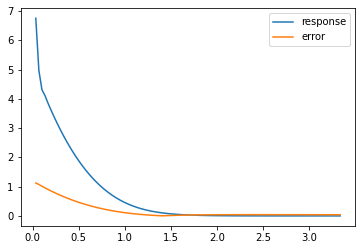

In [473]:
X = 800
Y = 800
AngularDrag = conf['AngularDrag']
AngularFriction = conf['AngularFriction']
Drag = conf['AirDrag']
Friction = conf['Friction']

pod_pos_0 = np.array([np.random.randint(X),np.random.randint(Y)])
theta0 = np.random.uniform(0,2*np.pi)
pod = PodClass.Pod(pos0 = pod_pos_0, w0 = 0, v0 = conf['v0'], a0 = conf['a0'], alpha0 = 0, theta0 = theta0,
                    m=conf['m_pod'], I=conf['I_pod'], TorqueMax = conf['TorqueMax'],
                    ThrustMax = conf['ThrustMax'], vMin = conf['vMin'], wMin = conf['wMin'], wMax = conf['wMax'])

pod.setDest((np.random.randint(X),np.random.randint(Y)))


# K0 = 5
# f0 = 0.3
# Kp = K0 * 1
# Ki = 0.2 * Kp * f0
# Kd = Kp / (9*f0)

K0 = 6
f0 = 0.4
Kp = K0 * 1
Ki = 0.2 * Kp * f0
Kd = Kp / (15*f0)

pod.PID_init(Kp,Ki,Kd)

tMax = 10
dt = 1/30
t=0

error_list = []
response_list = []
t_list = []

while t<tMax: # the main game loop
    t+=dt
    
    Torque,(v_desired,a_required) = pod.GetSteering_PID(pod.dest,dt)
    dist = np.linalg.norm(pod.dest - pod.pos)
    thetaDiff = abs(np.arccos(np.dot(Utils.unit_vector([np.cos(pod.theta),np.sin(pod.theta)]),Utils.unit_vector(pod.dest - pod.pos))))
    # if thetaDiff>(30/360.*2*np.pi):
    #     ThrustGauge = np.clip(np.cos(thetaDiff+30/360.*2*np.pi),0,1)
    # else:
    #     ThrustGauge = np.clip(np.cos(thetaDiff),0,1)
    pod.AddTorque(Torque = Torque)
    pod.Rotate(AngularDrag = AngularDrag, AngularFriction = AngularFriction, dt = dt)
    
    error_list.append(thetaDiff)
    response_list.append(Torque)
    t_list.append(t)
    
end = 100
plt.plot(t_list[:end],response_list[:end],label='response')
plt.plot(t_list[:end],error_list[:end],label='error')
plt.legend();
print(error_list[0])

In [425]:
90-15-45

30

In [426]:
30/360*2*np.pi

0.5235987755982988

In [428]:
pid.reset()?

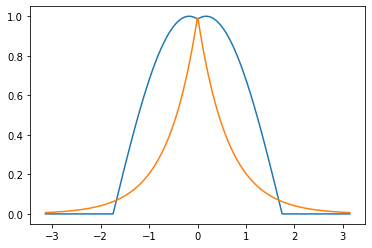

In [506]:
theta = np.linspace(-np.pi,np.pi,500)
plt.plot(theta,[np.clip(np.cos(abs(th)-10/360*2*np.pi),0,1) for th in theta])
plt.plot(theta,[np.clip(np.exp(-abs(th/(np.pi/5))),0,1) for th in theta])

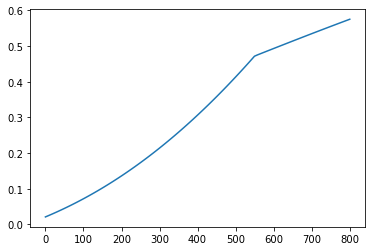

In [488]:
dist_list = np.linspace(0,800,100)
plt.plot(dist_list,[Utils.sigmoid(dist/700.)**2 * np.clip((dist+50)/600.,0,1) for dist in dist_list])

In [6]:
def CheckPointCheck(pod,CheckPointSize):
    return np.linalg.norm(pod.dest - pod.pos) < CheckPointSize

def calculateFitness(fitness,tMax):
    fitnessScore = {}
    for ID,scoreData in fitness.items():
        fitnessScore[ID] = len(scoreData)-1 - Utils.sigmoid(scoreData[-1]/tMax)
    return fitnessScore

conf['FPS'] = 30 #make simul fast
dt = conf['dt']
AngularDrag = conf['AngularDrag']
AngularFriction = conf['AngularFriction']
Drag = conf['AirDrag']
Friction = conf['Friction']

N = 10 # number of pods
M = 10 # number of checkpoints

# Sizes
X = 800
Y = 800
PODSIZE = (30,30)
CheckPointSize = 15

# create checkpoints
CheckGen = zip(np.random.randint(X,size=M),np.random.randint(Y,size=M))
checkpointList = [np.array(c) for c in CheckGen]

# initiate weights
W = np.zeros((6,32,32,2))

# Initiate Pod
# either use these options to generate pods with identical initial conditions, or set them further down to get unique settings for each pod (only for testing purposes)
# pod_pos_0 = np.array([np.random.randint(X),np.random.randint(Y)]) # random starting position
# theta0 = 3/2 * np.pi
podList = []
IDList = []

tMax = 120

# settings for PID controller
K0 = 90
f0 = 0.15
Kp = K0 * 0.5
Ki = 16 * Kp * f0
Kd = Kp / (8*f0)
for i in range(N):
    pod_pos_0 = np.array([np.random.randint(X),np.random.randint(Y)])
    theta0 = np.random.uniform(0,2*np.pi)
    pod = PodClass.Pod(pos0 = pod_pos_0, w0 = 0, v0 = conf['v0'], a0 = conf['a0'], alpha0 = 0, theta0 = theta0,
                        m=conf['m_pod'], I=conf['I_pod'], TorqueMax = conf['TorqueMax'],
                        ThrustMax = conf['ThrustMax'], vMin = conf['vMin'], wMin = conf['wMin'])
    pod.PID_init(Kp,Ki,Kd)
    podList.append(pod)
    IDList.append(pod.ID)


# initiate the first checkpoint for each pod:
for pod in podList:
    pod.setDest(checkpointList[0])

# initiate dict for fitnessScores
fitness = {}
for pod in podList:
    fitness[pod.ID] = [0]

# # compile a NN model for each pod
# for pod in podList:
#     pod.model = NN.BuildAndCompileModel()

# Set initial steering parameters
ThrustVec = np.zeros(N)
TorqueVec = np.zeros(N)

# in case you want to watch the result:
imgFile = '/Users/bjornahlgren/Documents/Privat/Projects/codingames/csb/SpaceShip2.png'

# Clock and FPS
fpsClock = pygame.time.Clock()
# Display
DISPLAYSURF = pygame.display.set_mode((X,Y), 0, 32)
pygame.display.set_caption('Pod training')
# Pods
podImgList = []
for pod in podList:
    podImg = pygame.image.load(imgFile).convert_alpha()
    podImg = pygame.transform.scale(podImg, PODSIZE)
    podImgList.append(podImg)

# def getPodStats(pod):
#     vx,vy           = pod.v
#     w               = pod.w
#     theta           = pod.theta
#     delta_x,delta_y = pod.dest - pod.pos
#     return np.array([vx,vy,w,theta,delta_x,delta_y])

# initiate x_train and y_train
x_train = []
y_train = []
for pod in podList:
    x_train.append(pod.getPodSteeringStats(dt))

    
updateParamsNr = 0
t = 0

while t<tMax: # the main game loop
    for event in pygame.event.get():
        if event.type in [pygame.QUIT,pygame.WINDOWEVENT_CLOSE,]:
            pygame.display.quit()
            pygame.quit()

    t+=dt
    updateParamsNr+=1
    DISPLAYSURF.fill(conf['WHITE'])

    for checkpoint in checkpointList:
        pygame.draw.circle(DISPLAYSURF, (0,0,150), checkpoint, CheckPointSize)

    for i,pod in enumerate(podList):

        ### Steering
        Torque,(v_desired,a_required) = pod.GetSteering_PID(pod.dest,dt)
        dist = np.linalg.norm(pod.dest - pod.pos)
        thetaDiff = abs(np.arccos(np.dot(Utils.unit_vector([np.cos(pod.theta),np.sin(pod.theta)]),Utils.unit_vector(pod.dest - pod.pos))))
        if thetaDiff>(30/360.*2*np.pi):
            ThrustGauge = np.clip(np.cos(thetaDiff+30/360.*2*np.pi),0,1)
        else:
            ThrustGauge = np.clip(np.cos(thetaDiff),0,1)
        ThrustGauge = ThrustGauge * Utils.sigmoid(dist/300.) * np.clip((dist+30)/300.,0,1)
        Thrust = conf['ThrustMax'] * ThrustGauge

        y_train.append(np.array([Thrust,Torque]))
        pod.Rotate(Torque = Torque, AngularDrag = AngularDrag, AngularFriction = AngularFriction, dt = dt)
        pod.Move(Thrust = Thrust, Drag = Drag, Friction = Friction, dt = dt)
        x_train.append(pod.getPodSteeringStats(delta_t=dt))
        
        if CheckPointCheck(pod,CheckPointSize):
            if pod.ID not in IDList:
                print(f'{pod.ID} not in IDList. wtf.')
            try:
                doneCheckPoints = ( len(fitness[pod.ID]) % M )
            except:
                print(fitness[pod.ID], sys.exc_info())
            pod.setDest(checkpointList[doneCheckPoints])
            fitness[pod.ID].append(t)



        pod_pos = np.rint(pod.pos).astype(int)
        goalVec = pod.dest - pod_pos

        pygame.draw.line(DISPLAYSURF,(255,0,0),pod_pos,pod_pos + goalVec)

        FT = np.array([Thrust*np.cos(pod.theta),Thrust*np.sin(pod.theta)])
        pygame.draw.line(DISPLAYSURF,(255,255,0),pod_pos,pod_pos + FT)
        pygame.draw.line(DISPLAYSURF,(255,0,255),pod_pos,pod_pos + pod.v)

        if (pod_pos[0] > 0) & (pod_pos[1] > 0):
            angle = (pod.theta + np.pi/2.)/(2*np.pi)*360. # note that +np.pi/2. comes from the fact that we want an initial rotation of 90 deg of the original image
            image_pivot = (PODSIZE[0]/2.,PODSIZE[1]/2.) # around the point which we rotate, in the coordinate system of the image
            surface_pivot = pod_pos # the point around which we rotate, in the coordinate system of the screen
            Visualise.blitRotate(DISPLAYSURF, podImgList[i], surface_pivot, image_pivot, -angle)
    pygame.display.update()
#     if updateParamsNr%20==0:
#         print(t)
    fpsClock.tick(conf['FPS'])


pygame.display.quit()
pygame.quit()

fitnessScore = calculateFitness(fitness,tMax)
for ID,score in fitnessScore.items():
    print(f'{ID} has a score of {score}')

x_train = np.array(x_train)
x_train = x_train[:-N]
y_train = np.array(y_train)
print('done')




140262721447248 has a score of 16.27313988138045
140262721446928 has a score of 16.272643826759886
140262721447440 has a score of 16.277045073111168
140262721447632 has a score of 16.270665249959603
140262721447760 has a score of 16.276211302620197
140262721448144 has a score of 16.271900801733757
140262721448272 has a score of 16.273967889885387
140262721448400 has a score of 16.269023350895385
140262721447824 has a score of 16.271076708006724
140262721448080 has a score of 16.271076708006724
done


In [511]:
import pandas as pd

In [535]:
df = pd.DataFrame(data = np.array([np.random.randn(1000),np.random.randn(1000)]).T)

In [536]:
df.to_csv('test.csv',index=False)

In [537]:
df = pd.read_csv('test.csv')

### Train model on these data to use as a nominal model for our AI

#### Create and save a scaler for the data. Also scale data

In [7]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
scalerpath = 'DataScalers/scaler_Model5.pkl'
pickle.dump(scaler, open(scalerpath, 'wb'))

#### Create and compile NN

In [8]:
model = keras.Sequential([
keras.layers.Flatten(input_shape=(6,)),
keras.layers.Dense(units=64,kernel_regularizer=keras.regularizers.l2(0.1), activation='relu'),
# keras.layers.Dropout(0.2),
keras.layers.Dense(units=64,kernel_regularizer=keras.regularizers.l2(0.1), activation='relu'),
# keras.layers.Dropout(0.2),
keras.layers.Dense(units=2)
])

BATCH_SIZE = 500
STEPS_PER_EPOCH = len(x_train)/BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

# result = l2_model(features)
# regularization_loss=tf.add_n(l2_model.losses)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
          loss='mean_absolute_error',
          metrics=['accuracy'])

In [9]:
from tqdm.keras import TqdmCallback

history = model.fit(x_train_scaled, y_train,validation_split=0.2,epochs=50,
                      verbose=0, callbacks=[TqdmCallback(verbose=0)])

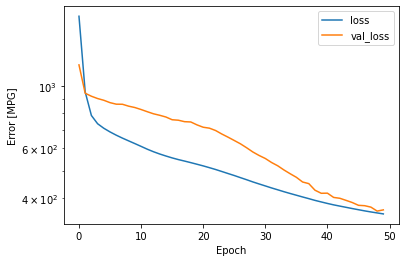

In [10]:
fig = NN.plot_loss(history)

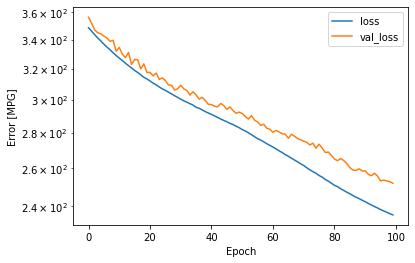

In [11]:
history = model.fit(x_train_scaled, y_train,
                      validation_split=0.2,
                      verbose=0, epochs=100)
fig = NN.plot_loss(history)

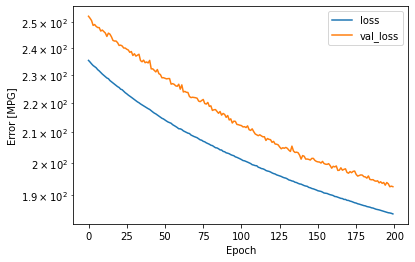

In [12]:
history = model.fit(x_train_scaled, y_train,
                      validation_split=0.2,
                      verbose=0, epochs=200)
fig = NN.plot_loss(history)

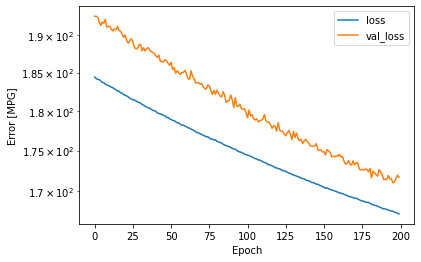

In [13]:
history = model.fit(x_train_scaled, y_train,
                      validation_split=0.2,
                      verbose=0, epochs=200)
fig = NN.plot_loss(history)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 4,738
Trainable params: 4,738
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.save('Models/conf1/Model5_Gen0')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/conf1/Model5_Gen0/assets


In [18]:
os.getcwd()

'/Users/bjornahlgren/Documents/Privat/Projects/codingames/csb'

In [136]:
# modFile1 = 'Models/conf1/Model1_Gen1'

modFile1 = 'Models/conf1/Model1_Gen1'
modFile2 = 'Models/conf1/Model2_Gen1'
modFile3 = 'Models/conf1/Model3_Gen1'
# model1 = keras.models.load_model(modFile1,compile=False)

model1 = keras.models.load_model(modFile1,compile=True)
model2 = keras.models.load_model(modFile2,compile=True)
model3 = keras.models.load_model(modFile3,compile=True)

model1_nc = keras.models.load_model(modFile1,compile=False)
model2_nc = keras.models.load_model(modFile2,compile=False)
model3_nc = keras.models.load_model(modFile3,compile=False)

### Evaluate model on new data in test

In [137]:
model = model3_nc
# pickle.dump(scaler, open('scaler_Model4.pkl', 'wb'))
scalerPath = 'DataScalers/scaler_Model1.pkl'
scaler = pickle.load(open(scalerPath, 'rb'))

def CheckPointCheck(pod,CheckPointSize):
    return np.linalg.norm(pod.dest - pod.pos) < CheckPointSize

def calculateFitness(fitness,tMax):
    fitnessScore = {}
    for ID,scoreData in fitness.items():
        fitnessScore[ID] = len(scoreData)-1 - Utils.sigmoid(scoreData[-1]/tMax)
    return fitnessScore

def getPodStats(pod):
    vx,vy           = pod.v
    w               = pod.w
    theta           = pod.theta
    delta_x,delta_y = pod.dest - pod.pos
    return np.array([vx,vy,w,theta,delta_x,delta_y])

conf['FPS'] = 100 #make simul fast
dt = conf['dt']
AngularDrag = conf['AngularDrag']
AngularFriction = conf['AngularFriction']
Drag = conf['AirDrag']
Friction = conf['Friction']

N = 2 # number of pods
M = 10 # number of checkpoints

# Sizes
X = 800
Y = 800
PODSIZE = (30,30)
CheckPointSize = 15

# create checkpoints
CheckGen = zip(np.random.randint(X,size=M),np.random.randint(Y,size=M))
checkpointList = [np.array(c) for c in CheckGen]

# Initiate Pod
# either use these options to generate pods with identical initial conditions, or set them further down to get unique settings for each pod (only for testing purposes)
# pod_pos_0 = np.array([np.random.randint(X),np.random.randint(Y)]) # random starting position
# theta0 = 3/2 * np.pi
podList = []
IDList = []
for i in range(N):
    pod_pos_0 = np.array([np.random.randint(X),np.random.randint(Y)])
    theta0 = np.random.uniform(0,2*np.pi)
    pod = PodClass.Pod(pos0 = pod_pos_0, w0 = 0, v0 = conf['v0'], a0 = conf['a0'], alpha0 = 0, theta0 = theta0,
                        m=conf['m_pod'], I=conf['I_pod'], TorqueMax = conf['TorqueMax'],
                        ThrustMax = conf['ThrustMax'], vMin = conf['vMin'], wMin = conf['wMin'])
    podList.append(pod)
    IDList.append(pod.ID)

# initiate the first checkpoint for each pod:
for pod in podList:
    pod.setDest(checkpointList[0])

# initiate dict for fitnessScores
fitness = {}
for pod in podList:
    fitness[pod.ID] = [0]

# # compile a NN model for each pod
# for pod in podList:
#     pod.model = model

# Set initial steering parameters
ThrustVec = np.zeros(N)
TorqueVec = np.zeros(N)

# in case you want to watch the result:
imgFile = '/Users/bjornahlgren/Documents/Privat/Projects/codingames/csb/SpaceShip2.png'

# Clock and FPS
fpsClock = pygame.time.Clock()
# Display
DISPLAYSURF = pygame.display.set_mode((X,Y), 0, 32)
pygame.display.set_caption('Pod training')
# Pods
podImgList = []
for pod in podList:
    podImg = pygame.image.load(imgFile).convert_alpha()
    podImg = pygame.transform.scale(podImg, PODSIZE)
    podImgList.append(podImg)
    
updateParamsNr = 0
t = 0
tMax = 20
while t<tMax: # the main game loop
    for event in pygame.event.get():
        if event.type in [pygame.QUIT,pygame.WINDOWEVENT_CLOSE,]:
            pygame.display.quit()
            pygame.quit()

    t+=dt
    updateParamsNr+=1
    DISPLAYSURF.fill(conf['WHITE'])

    for checkpoint in checkpointList:
        pygame.draw.circle(DISPLAYSURF, (0,0,150), checkpoint, CheckPointSize)

    for i,pod in enumerate(podList):
        x = scaler.transform(np.array([pod.getPodSteeringStats(delta_t=dt)]))
        Thrust,Torque = pod.NN_getSteering(x)
#         x = scaler.transform(np.array([getPodStats(pod)]))
#         Thrust,Torque = model1(x)[0]
#         (Torque,Thrust),(v_desired,a_required,w_required,alpha_required) = pod.GetSteering(pod.dest,dt)
#         y_train.append(np.array([Thrust,Torque]))
        pod.Rotate(Torque = Torque, AngularDrag = AngularDrag, AngularFriction = AngularFriction, dt = dt)
        pod.Move(Thrust = Thrust, Drag = Drag, Friction = Friction, dt = dt)
#         x_train.append(getPodStats(pod))

        if CheckPointCheck(pod,CheckPointSize):
            if pod.ID not in IDList:
                print(f'{pod.ID} not in IDList. wtf.')
            try:
                doneCheckPoints = ( len(fitness[pod.ID]) % M )
            except:
                print(fitness[pod.ID], sys.exc_info())
            pod.setDest(checkpointList[doneCheckPoints])
            fitness[pod.ID].append(t)



        pod_pos = np.rint(pod.pos).astype(int)
        goalVec = pod.dest - pod_pos

        pygame.draw.line(DISPLAYSURF,(255,0,0),pod_pos,pod_pos + goalVec)

        FT = np.array([Thrust*np.cos(pod.theta),Thrust*np.sin(pod.theta)])
        pygame.draw.line(DISPLAYSURF,(255,255,0),pod_pos,pod_pos + FT)
        pygame.draw.line(DISPLAYSURF,(255,0,255),pod_pos,pod_pos + pod.v)

        if (pod_pos[0] > 0) & (pod_pos[1] > 0):
            angle = (pod.theta + np.pi/2.)/(2*np.pi)*360. # note that +np.pi/2. comes from the fact that we want an initial rotation of 90 deg of the original image
            image_pivot = (PODSIZE[0]/2.,PODSIZE[1]/2.) # around the point which we rotate, in the coordinate system of the image
            surface_pivot = pod_pos # the point around which we rotate, in the coordinate system of the screen
            Visualise.blitRotate(DISPLAYSURF, podImgList[i], surface_pivot, image_pivot, -angle)
    pygame.display.update()
#     if updateParamsNr%20==0:
#         print(t)
    fpsClock.tick(conf['FPS'])


pygame.display.quit()
pygame.quit()

fitnessScore = calculateFitness(fitness,tMax)
for ID,score in fitnessScore.items():
    print(f'{ID} has a score of {score}')

print('done')



140582443149200 has a score of 1.3062945980446008
140583467839760 has a score of 0.34864513533394526
done


In [261]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl

In [326]:
# def anim_init():
    
def animate(i,podList):
    for pod in podList:
        pod.patch.center = tuple(pod.pos)

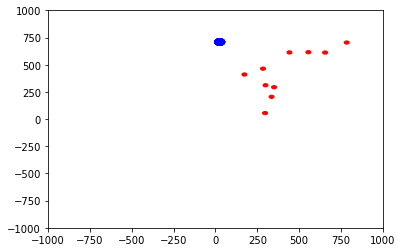

In [323]:
fig,ax = plt.subplots()
ax.set_xlim([-1000,1000])
ax.set_ylim([-1000,1000])
cpFigs = [plt.Circle(cp, CheckPointSize, color='r') for cp in checkpointList]
for j,pod in enumerate(podList):
    podPatch = plt.Circle((pod_pos)+(5*i,5*i), PODSIZE[0], color='b')
    pod.patch = podPatch
    ax.add_patch(podPatch)
# podFigs = [ for j,pod in enumerate(podList[-1:])] #fix unique colors for all pods!
# for podFig in podFigs:
#     ax.add_patch(podFig)
for cpFig in cpFigs:
    ax.add_artist(cpFig)

In [324]:
anim = FuncAnimation(fig,animate,frames = None,fargs=(podList,),
              blit=False)


In [325]:
HTML(anim.to_html5_video())

TypeError: animate() takes 1 positional argument but 2 were given

In [171]:
reload(GPS)
reload(GPS.PhysicalObjects)
reload(GPS.Utils)
reload(PodClass)
reload(GPS.Config)
reload(Utils)
reload(NN)

# import GamePhysicsSim as GPS
# import GamePhysicsSim.Pod as PodClass
# from GamePhysicsSim.Config import conf
# import GamePhysicsSim.Utils as Utils

<module 'GamePhysicsSim.NN' from '/Users/bjornahlgren/Documents/pythonModuleWorkShop/GamePhysicsSim/GamePhysicsSim/NN.py'>